In [1]:
from cube import Cube
from tile import Tile
from ck2map import CK2Map
from continent_gen import *
import random
from border_doodler import BorderDoodler
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [2]:
random_k_cols = [(np.random.randint(128, 256), 64, 64) for _ in range(300)]
random_d_cols = [(64,np.random.randint(128, 256), 64) for _ in range(300)]
random_c_cols = [(np.random.randint(64, 256),64,np.random.randint(64, 256)) for _ in range(300)]

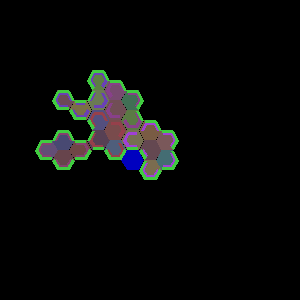

In [3]:
cd = make_capital_duchy(rgb_tuple=(random_d_cols.pop(), random_c_cols[:6]))
bd = BorderDoodler(cd, size=(300,300))
bd.im

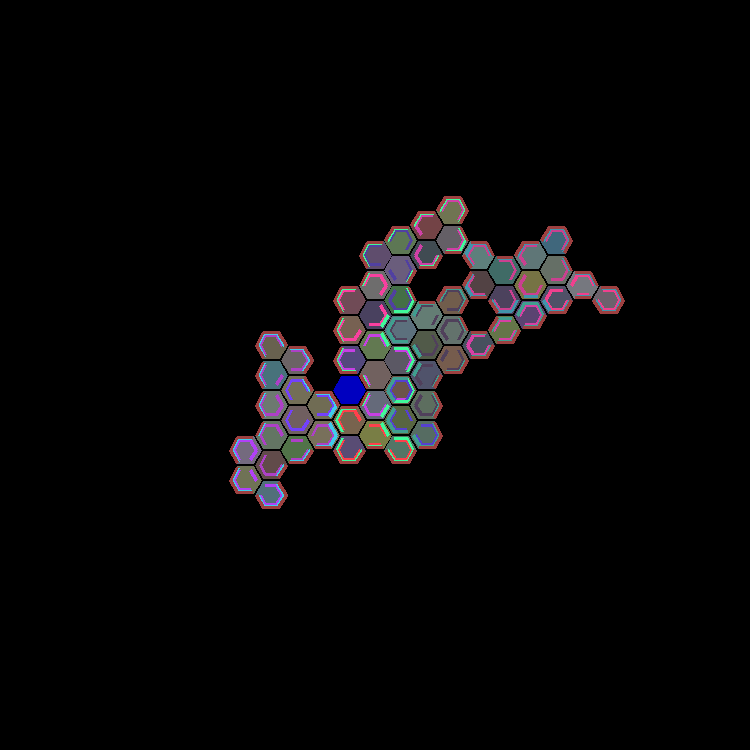

In [4]:
kingdom = make_kingdom()
bdk = BorderDoodler(kingdom, size=(750,750),radius=15)
bdk.im

In [2]:
import time

In [3]:
start_time = time.time()
continent, kingdoms = new_continent_gen(5)
end_time = time.time()
print(end_time-start_time)

border duchies 3
water access bd 3
border duchies 3
border duchies 3
move into place
border duchies 3
border duchies 3
border duchies 3
water access 0
border duchies 3
water access 0
Added 3 kingdoms!
Added 4 kingdoms!
add fifth kingdom
Added 3 kingdoms!
Added 4 kingdoms!
Added 5 kingdoms!
{'border duchies 3': 7, 'water access bd 3': 1, 'move into place': 1, 'water access 0': 2, 'add fifth kingdom': 1}
57.237277030944824


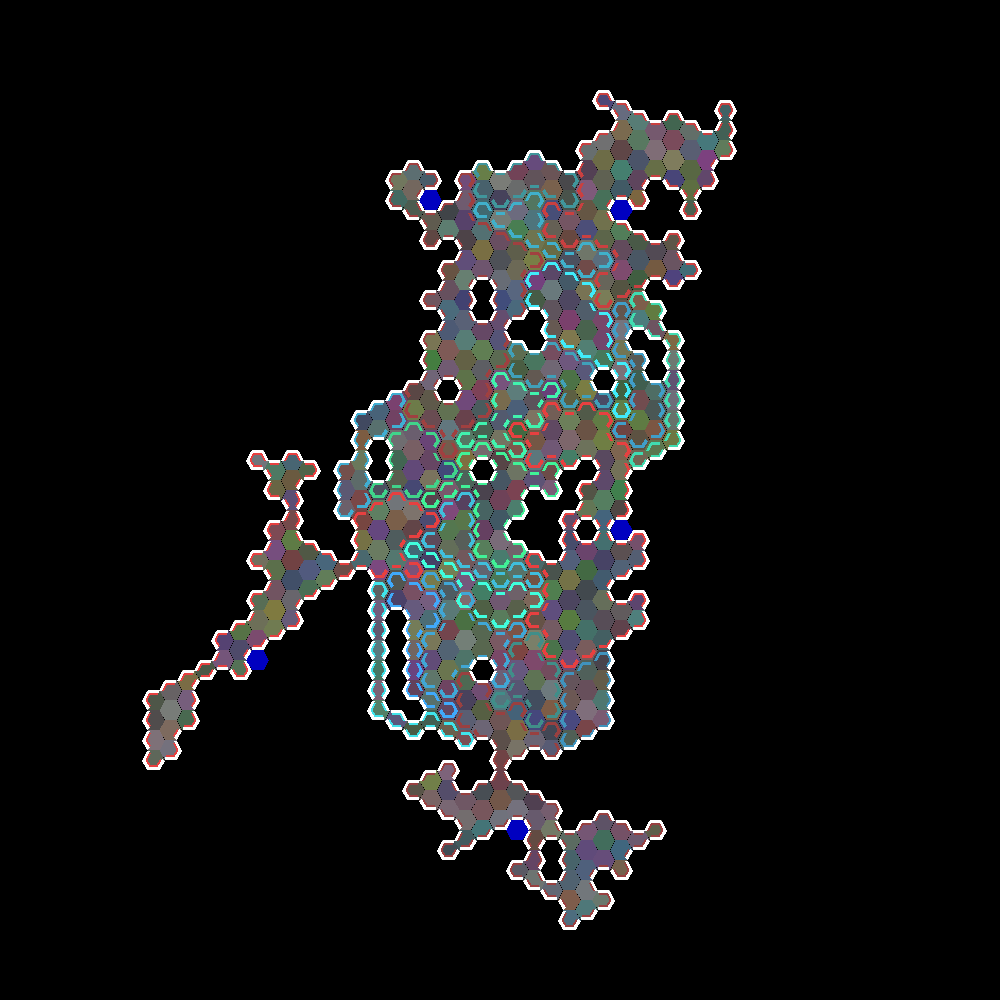

In [4]:
bdc = BorderDoodler(continent, size=(1000,1000),radius=10, depth=1)
bdc.im

In [5]:
import os
def make_mod(file_dir, mod_name, mod_disp_name):
    '''Build the basic mod details.'''
    f = open(os.path.join(file_dir,"{}.mod".format(mod_name)),'w')
    f.write("name = \"{}\"\npath = \"mod/{}\"\nuser_dir = \"{}\"\n".format(mod_disp_name, mod_name, mod_name))
    f.write("tags = {\n\t\"Total Conversion\"\n}\n")
    replace_paths = ["common/landed_titles", "map_data"] #"common/bookmarks", "common/cultures", "common/dynasties", 
                        #"common/offmap_powers", "history/characters", "history/offmap_powers", "history/provinces",
                        #"history/technology", "history/titles", "history/wars"]
    f.write("replace_path = \"" + "\"\nreplace_path = \"".join(replace_paths)+"\"")
    f.close()

In [7]:
make_mod('C:\\Users\\Vaniver\\Documents\\Paradox Interactive\\Crusader Kings III', 'map_test','Map Test')